In this notebook, we present a collection of mobility data from NextBike. The data set is normalized and afterwards clustered and visualized in a network.

## Dependencies and Settings

In [2]:
import pandas as pd
#import graph_tool.all as gt
#import compsoc as cs
import numpy as np
import matplotlib.pyplot as plt
#import folium
#from folium import plugins
#from shapely.geometry import Point
import warnings
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
#import overpy
from IPython.core.display import HTML
import requests
import json
from pandas.io.json import json_normalize

%matplotlib inline

In [ ]:
warnings.filterwarnings("ignore")

## Read in the mobility data set

The given data set is retrieved via NextBike's API and already preprocessed.

In [10]:
mobility_data = pd.read_csv("output_datasets/cleaned_data_nextbike_2019-12.csv.gz", sep=";", low_memory=False)
mobility_data

,lat,lng,time_begin,time_end,name,address,bike,bike_racks,bikes,booked_bikes,...,rack_locks,special_racks,spot,terminal_type,uid,city,country_code,company,timezone,available_bikes
0,50.927503,7.005390,2019-12-01 00:00:02.682133,2019-12-01 19:32:02.528443,BIKE 21176,NaN,True,0,1,0,...,False,0,False,NaN,25485984,Köln,DE,Nextbike,Europe/Berlin,2623
1,50.914807,6.999803,2019-12-01 19:46:02.847699,2019-12-01 19:46:02.847699,BIKE 21176,NaN,True,0,1,0,...,False,0,False,NaN,25526597,Köln,DE,Nextbike,Europe/Berlin,2626
2,50.914818,6.999822,2019-12-01 19:47:03.193318,2019-12-03 19:15:02.855113,BIKE 21176,NaN,True,0,1,0,...,False,0,False,NaN,25526597,Köln,DE,Nextbike,Europe/Berlin,2627
3,50.910324,6.999764,2019-12-03 19:24:02.650992,2019-12-03 19:24:02.650992,BIKE 21176,NaN,True,0,1,0,...,False,0,False,NaN,25601187,Köln,DE,Nextbike,Europe/Berlin,2607
4,50.910249,6.999861,2019-12-03 19:25:02.921311,2019-12-05 10:48:02.779322,BIKE 21176,NaN,True,0,1,0,...,False,0,False,NaN,25601187,Köln,DE,Nextbike,Europe/Berlin,2605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106478,50.946561,6.886962,2019-12-16 09:12:02.407163,2019-12-16 18:29:02.242488,BIKE 21633,NaN,True,0,1,0,...,False,0,False,NaN,26047556,Köln,DE,Nextbike,Europe/Berlin,2629
106479,50.910273,6.945931,2019-12-16 19:01:02.265246,2019-12-16 19:01:02.265246,BIKE 21633,NaN,True,0,1,0,...,False,0,False,NaN,26068204,Köln,DE,Nextbike,Europe/Berlin,2572
106480,50.910307,6.945997,2019-12-16 19:02:02.202549,2019-12-16 19:27:02.937458,BIKE 21633,NaN,True,0,1,0,...,False,0,False,NaN,26068204,Köln,DE,Nextbike,Europe/Berlin,2573
106481,50.909102,6.936214,2019-12-16 19:42:02.045320,2019-12-16 19:42:02.045320,BIKE 21633,NaN,True,0,1,0,...,False,0,False,NaN,26069660,Köln,DE,Nextbike,Europe/Berlin,2599


## Normalization

Before applying methods on the data set, we need to normalize it. The data set is normalized by using [Haiko Lietz' ER Modell](https://github.com/gesiscss/compsoc/blob/master/images/er_model.png).

### Extract bike table

The bike-specific columns are extracted and a bike ID for each bike is added.

In [11]:
bikes = mobility_data[["name"]].drop_duplicates().reset_index(drop=True)
bikes["bike_id"]=bikes.index
bikes = bikes[["bike_id", "name"]]
bikes

,bike_id,name
0,0,BIKE 21176
1,1,BIKE 21218
2,2,BIKE 21388
3,3,BIKE 22780
4,4,BIKE 21097
...,...,...
1111,1111,BIKE 22849
1112,1112,BIKE 21563
1113,1113,BIKE 22225
1114,1114,BIKE 22437


### Extract place table

The place table contains every place where a bike has been parked. 

Every place has an uid and a latitude/longitude combination. A place ID is added.

A uid has to be unique because for every movement of a bike the uid changes.

In [12]:
places = mobility_data[["uid", "lat", "lng", "place_type", "bike_racks", "address", "city", "country_code"]].reset_index(drop=True)
places["place_id"] = places.index
places = places[["place_id", "uid", "lat", "lng", "place_type", "bike_racks", "address", "city", "country_code"]]
places

,place_id,uid,lat,lng,place_type,bike_racks,address,city,country_code
0,0,25485984,50.927503,7.005390,12,0,NaN,Köln,DE
1,1,25526597,50.914807,6.999803,12,0,NaN,Köln,DE
2,2,25526597,50.914818,6.999822,12,0,NaN,Köln,DE
3,3,25601187,50.910324,6.999764,12,0,NaN,Köln,DE
4,4,25601187,50.910249,6.999861,12,0,NaN,Köln,DE
...,...,...,...,...,...,...,...,...,...
106478,106478,26047556,50.946561,6.886962,12,0,NaN,Köln,DE
106479,106479,26068204,50.910273,6.945931,12,0,NaN,Köln,DE
106480,106480,26068204,50.910307,6.945997,12,0,NaN,Köln,DE
106481,106481,26069660,50.909102,6.936214,12,0,NaN,Köln,DE


Check for duplicates in column ```uid```.

In [13]:
places["uid"].duplicated().any()

True

In [14]:
places[places.duplicated(["uid"])]

,place_id,uid,lat,lng,place_type,bike_racks,address,city,country_code
2,2,25526597,50.914818,6.999822,12,0,NaN,Köln,DE
4,4,25601187,50.910249,6.999861,12,0,NaN,Köln,DE
7,7,25664853,50.943570,6.960012,12,0,NaN,Köln,DE
9,9,25666457,50.921652,6.963210,12,0,NaN,Köln,DE
11,11,25667799,50.939109,6.950386,12,0,NaN,Köln,DE
...,...,...,...,...,...,...,...,...,...
106474,106474,26038347,50.951051,6.927066,12,0,NaN,Köln,DE
106476,106476,26043700,50.948473,6.915046,12,0,NaN,Köln,DE
106478,106478,26047556,50.946561,6.886962,12,0,NaN,Köln,DE
106480,106480,26068204,50.910307,6.945997,12,0,NaN,Köln,DE


### Extract transaction table


The transactions indicates the __standing time__ of a bike at a specific place.

Therefore __time_begin__ marks when a bike was parked and __time_end__ marks when a bike was taken for the next ride. 

In [8]:
transactions = mobility_data[["time_begin", "time_end", "standing_time_minutes", "timezone", "name", "uid"]]
transactions["transaction_id"] = transactions.index
transactions = transactions[["transaction_id", "time_begin", "time_end", "standing_time_minutes", "timezone", "name", "uid"]]
transactions.head()

,transaction_id,time_begin,time_end,standing_time_minutes,timezone,name,uid
0,0,2019-12-01 00:00:02.682133,2019-12-01 19:32:02.528443,1172.0,Europe/Berlin,BIKE 21176,25485984
1,1,2019-12-01 19:46:02.847699,2019-12-03 19:15:02.855113,2849.0,Europe/Berlin,BIKE 21176,25526597
2,2,2019-12-03 19:24:02.650992,2019-12-05 10:48:02.779322,2364.0,Europe/Berlin,BIKE 21176,25601187
3,3,2019-12-05 11:10:03.195169,2019-12-05 12:02:02.795394,52.0,Europe/Berlin,BIKE 21176,25662337
4,4,2019-12-05 12:20:02.586012,2019-12-05 12:50:02.732413,30.0,Europe/Berlin,BIKE 21176,25664853


### Due to the IDs we added to bikes table and place table as primary keys, we need to replace the values of the columns _uid_ and _bikes_ with their corresponding primary key (ID).

In [9]:
def add_pk_to_table(df):
    """
    Description: We need to replace the uid and the bike names with their primary key from the place/bike tables.
    Input: First two columns of a data frame, containing the ID as primary key and the name.
    Output: A list containing the corresponding primary key (ID) of each transaction.
    """
    
    dic = {}
    columns = df.columns
    name = columns[1]
    name_id = columns[0]
    for index, row in df.iterrows():
        dic[df[name][index]] = df[name_id][index]

    ls_id = []
    for i in transactions[name]:
        ls_id.append(dic[i])

    return ls_id

bikes_id = add_pk_to_table(bikes)
places_id = add_pk_to_table(places)

The columns "bike_id" and "uid" of the transaction data frame are replaced with the result lists (```bikes_id``` and ```places_id```) of the ```ad_pk_to_table``` function.

In [10]:
transactions["bike_id"] = bikes_id
transactions["place_id"] = places_id

transactions = transactions[["transaction_id", "place_id", "bike_id", "time_begin", "time_end", "standing_time_minutes", "timezone"]]
transactions.head()

,transaction_id,place_id,bike_id,time_begin,time_end,standing_time_minutes,timezone
0,0,0,0,2019-12-01 00:00:02.682133,2019-12-01 19:32:02.528443,1172.0,Europe/Berlin
1,1,1,0,2019-12-01 19:46:02.847699,2019-12-03 19:15:02.855113,2849.0,Europe/Berlin
2,2,2,0,2019-12-03 19:24:02.650992,2019-12-05 10:48:02.779322,2364.0,Europe/Berlin
3,3,3,0,2019-12-05 11:10:03.195169,2019-12-05 12:02:02.795394,52.0,Europe/Berlin
4,4,4,0,2019-12-05 12:20:02.586012,2019-12-05 12:50:02.732413,30.0,Europe/Berlin


### transaction_places table & transaction_bikes table

In [11]:
transactions_places = transactions[["transaction_id", "place_id"]]
transactions_bikes = transactions[["transaction_id", "bike_id"]]

### rides table

Due to the fact that the transaction table records the standing time of a bike, we need to create a table that contains the rides.

Therefore we iterate over the bike table and extract the corresponding rows and put it in a list. We drop the first value and append 0 at the end of the list.

In [12]:
def extract_columns(df_tr, column, df_input, id_list):
    """
    Input: df_tr = transaction table, column = column, that needs to be extracted, df_input = data frame that contains unique ids, id_list = column that contains ids
    Output: columns needed to build rides table (only foreign keys)
    """
    result = []
    for i in df_input[id_list]:
        data = df_tr[df_tr[id_list] == i]
        values = list(data[column])
        values.pop(0)
        values.append(0)
        for v in values:
            result.append(v)
        
    return result

transaction = extract_columns(transactions, "transaction_id", bikes, "bike_id")
place = extract_columns(transactions, "place_id", bikes, "bike_id")

Now we can build the rides table.

In [13]:
rides = transactions[["transaction_id", "place_id", "bike_id"]]
rides["transaction_id_to"] = transaction
rides["place_id_to"] = place
rides = rides[["transaction_id", "transaction_id_to", "place_id", "place_id_to", "bike_id"]]
rides.rename(columns={"transaction_id" : "transaction_id_from", "place_id" : "place_id_from"}, inplace=True)
rides.head()

,transaction_id_from,transaction_id_to,place_id_from,place_id_to,bike_id
0,0,1,0,1,0
1,1,2,1,2,0
2,2,3,2,3,0
3,3,4,3,4,0
4,4,5,4,5,0


In the function _extract_columns_ we added the value 0 at the end of the list because the list length and the data frame length need to be of equal length so that the list could be added. Now we drop the last row with the value 0 because that's no ride.

Additionally we add an index.

In [14]:
rides.drop(rides[rides["transaction_id_to"] == 0].index, inplace=True)
rides = rides.reset_index(drop=True)
rides["rides_id"] = rides.index
rides.head()

,transaction_id_from,transaction_id_to,place_id_from,place_id_to,bike_id,rides_id
0,0,1,0,1,0,0
1,1,2,1,2,0,1
2,2,3,2,3,0,2
3,3,4,3,4,0,3
4,4,5,4,5,0,4


## Clustering

Function

In [15]:
def create_df(X, y):
    """
    Description: Function to create the data frame that includes all lat/lon combinations (X) and the predicted clusters (y). 
    Input: Numpy array with lat/lon combinations, predicted clusters
    Output: Data frame with all geo points and the corresponding cluster and further information:
            size = size of cluster
            fraction = how big is the fraction of the total
            radius = the distance to mean coordinate 
    """
    # store coordinates and cluster affiliations in dataframe
    df = pd.DataFrame([X[:, 0], X[:, 1], y]).T
    df.columns = ['x', 'y', 'cluster']
    df['cluster'] = df['cluster'].astype(int)
    # get mean coordinates
    df_mean = df.groupby('cluster').mean().reset_index()
    # get size of clusters
    df_size = pd.DataFrame(df.groupby('cluster').size())
    # combine information in one dataframe
    df_c = pd.concat([df_mean, df_size], axis=1)
    df_c.columns = ['cluster', 'lat_mean', 'lng_mean', 'size']
    df_c['fraction'] = df_c['size']/len(df)
    # append information to original dataframe
    df = pd.merge(left=df, right=df_c, on='cluster')
    # get distance to mean coordinate
    df['radius'] = ((df['x']-df['lat_mean'])**2+(df['y']-df['lng_mean'])**2)**.5
    # return final dataframe
    return df

#### Select clustering methods and parameters

In [16]:
clustering_method = ['agglomerative', 'kmeans'][0]

#### Select radius of the clusters.
```r = 0.001``` equals 100 meters

Radius means the radius of the clusters.

Methods:


In [17]:
r = 0.005

With ```radius_method``` you decide how the number of clusters is detected. 

```radius_method = "max_of_largest"``` = The maximum radius of the largest cluster is minimized to ```r```.

```radius_method = "max"``` = All clusters have a radius smaller than ```r```.

```radius_method = "mean"``` = The average radius of all clusters is minimized to ```r```.

In [18]:
radius_method = ["max_of_largest", "max", "mean"][0]
# max_of_largest has the desired effect that large clusters have small radii but smaller ones can be dispersed more

#### Due to the data size, three random sample are used for finding the optimal number of clusters.

In [19]:
places_sample_1 = places.sample(n = 5000)
places_sample_2 = places.sample(n = 5000)
places_sample_3 = places.sample(n = 5000)

#### To detect the optimal amount of clusters, the geo points of the sample data frames are put into numpy arrays. 

In [20]:
points = places_sample_1.loc[:,["lat", "lng"]]
X_points_sample1 = np.array(points)

points = places_sample_2.loc[:,["lat", "lng"]]
X_points_sample2 = np.array(points)

points = places_sample_3.loc[:,["lat", "lng"]]
X_points_sample3 = np.array(points)

#### To comupte the clusters after detecting the optimal number of clusters, all geo points of the data frame places are put into a numpy array.

In [21]:
points = places.loc[:,["lat", "lng"]]
X_points = np.array(points)
X_points

array([[50.92750347,  7.00539032],
       [50.91481817,  6.99982215],
       [50.91024948,  6.9998609 ],
       ...,
       [50.94656095,  6.88696225],
       [50.91030727,  6.94599705],
       [50.9091576 ,  6.93636213]])

#### Let's see how the unclustered data looks like.

Text(0, 0.5, 'latitude')

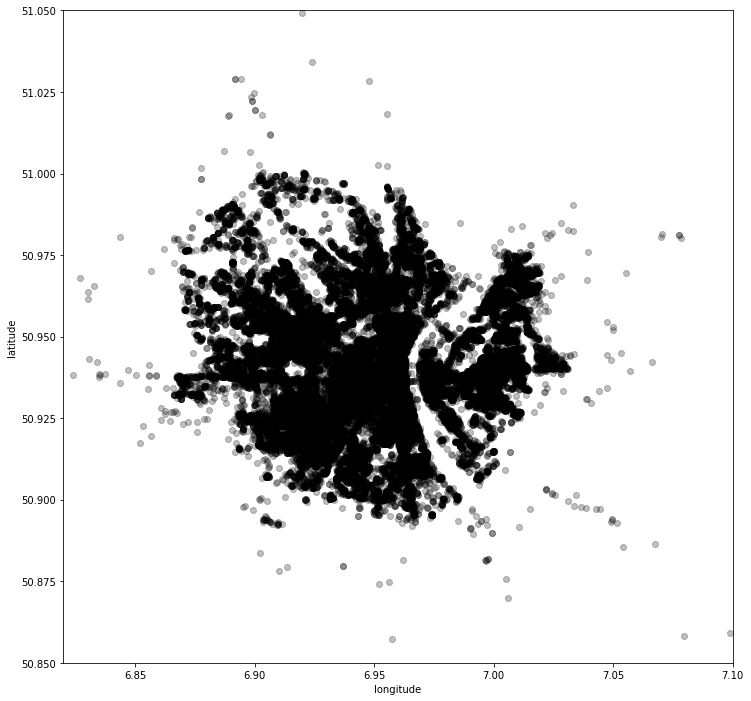

In [22]:
plt.figure(figsize=(12,12))
plt.ylim(50.85, 51.05)
plt.xlim(6.82, 7.1)
plt.scatter(X_points[:, 1], X_points[:, 0], c="black", alpha=0.25)
plt.xlabel('longitude')
plt.ylabel('latitude')

### Finding out the optimal number of clusters.
For that we use all three sample data.

In [23]:
def detect_n_opt(sample, num_clusters):
    """
    Description:
    Input:
    Output:    
    """
    
    scores = []
    radiuses = []
    for n in range(2, num_clusters):
        if clustering_method == 'agglomerative':
            clust = AgglomerativeClustering(n_clusters=n)
        if clustering_method == 'kmeans':
            clust = KMeans(num_clusters=n)
        y_points = clust.fit_predict(sample)
        scores.append(metrics.silhouette_score(sample, y_points, metric="euclidean"))
        df = create_df(sample, y_points)
        if radius_method == 'max_of_largest':
            radiuses.append(df[df['size'] == df['size'].max()].groupby('cluster').max()['radius'].tolist()[0])
        if radius_method == 'max':
            radiuses.append(df.groupby('cluster').max()['radius'].tolist()[0])        
        if radius_method == 'mean':
            radiuses.append(df['radius'].mean())
    
    n_opt = 2+next(x[0] for x in enumerate(radiuses) if x[1] <= r)
    
    return df, radiuses, n_opt

In [24]:
num_clusters = 200

In [25]:
df_1, radiuses_1, n_opt_1 = detect_n_opt(X_points_sample1, num_clusters)
df_2, radiuses_2, n_opt_2 = detect_n_opt(X_points_sample2, num_clusters)
df_3, radiuses_3, n_opt_3 = detect_n_opt(X_points_sample3, num_clusters)

In [26]:
print(n_opt_1, n_opt_2, n_opt_3)
n_opt = np.mean([n_opt_1, n_opt_2, n_opt_3], dtype=np.int)
n_opt

165 154 178


165

#### Now we can compute the clusters with optimal number of clusters.

In [27]:
def clustering(X_points, n_opt_clusters):
    """
    Description:
    Input:
    Output:
    """

    if clustering_method == 'agglomerative':
        clust = AgglomerativeClustering(n_clusters=n_opt_clusters)
    if clustering_method == 'kmeans':
        clust = KMeans(n_clusters=n_opt_clusters)
    y_points = clust.fit_predict(X_points)

    df_cluster = create_df(X_points, y_points)

    df_cluster.rename(columns={"x": "lat", "y": "lng"}, inplace=True)
    return df_cluster

In [28]:
df_cluster = clustering(X_points, n_opt)

MemoryError: unable to allocate array data.

In [ ]:
df_cluster

#### The data frame ```df_cluster``` includes all geo points and cluster information.

In [ ]:
df_cluster.rename(columns={"x": "lat", "y": "lng", "radius": "distance"}, inplace=True)
df_cluster

#### Now we can extract the cluster information and create a data frame containing only cluster information.

In [31]:
df_cluster_p = df_cluster.groupby('cluster').max().reset_index()
df_cluster_p.drop(['lat', 'lng'], axis=1, inplace=True)
df_cluster_p.rename(columns={'distance': 'max_radius'}, inplace=True)
# sort descendingly on fraction
df_cluster_p = df_cluster_p.sort_values('fraction', ascending=False).reset_index(drop=True)

In [33]:
df_cluster_p

,cluster,lat_mean,lng_mean,size,fraction,max_radius
0,49,50.942417,6.959021,1608,0.026483,0.007430
1,7,50.912692,6.942378,1341,0.022086,0.008467
2,44,50.927691,6.937698,1328,0.021872,0.005444
3,35,50.937576,6.939812,1288,0.021213,0.006337
4,28,50.935620,6.958918,1268,0.020883,0.009461
...,...,...,...,...,...,...
112,111,48.844482,12.814610,1,0.000016,0.000000
113,85,50.851501,7.738799,1,0.000016,0.000000
114,84,51.026430,7.653523,1,0.000016,0.000000
115,83,50.974147,6.149536,1,0.000016,0.000000


Not working (shapefile, geopandas)

In [34]:
#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(111)

#cmap=plt.get_cmap('Greys')

#data_kb.plot(ax=ax)

# get axes limits after plotting shapefile
#x0, x1, y0, y1 = plt.axis()
#plt.xlim(x0, x1)
#plt.ylim(y0, y1)

#plt.xlim(6.85, 7.02)
#plt.ylim(50.9, 51)


# plot geo points
#ax.scatter(df_cluster_p.y_mean, df_cluster_p.x_mean, c="black", alpha=0.5, cmap=plt.cm.Set2)

# plot centers
#ax.scatter(centers[:, 1], centers[:, 0], s=200, c="red", marker = "s", alpha=0.5)

## Modification of the data scheme

### Modify the place table (FACTS) so that it includes all identified clusters.

Merge the ```df_clusters``` data frame on ```places``` data frame so that the new data frame includes all geo points and the indetified clusters.

In [35]:
stations = pd.merge(places, df_cluster.loc[:, ["cluster", "lat", "lng", "lat_mean", "lng_mean", "size", "distance"]],  how="right", on=["lat", "lng"]).drop_duplicates()

In [36]:
stations.head()

,place_id,uid,lat,lng,place_type,bike_racks,address,city,country_code,cluster,lat_mean,lng_mean,size,distance
0,0,25485984,50.927503,7.005390,12,0,NaN,Köln,DE,90,50.927004,7.008514,168,0.003163
1,1,25526597,50.914818,6.999822,12,0,NaN,Köln,DE,4,50.906414,6.995627,208,0.009394
2,2,25601187,50.910249,6.999861,12,0,NaN,Köln,DE,4,50.906414,6.995627,208,0.005713
3,3,25662337,50.908960,6.970103,12,0,NaN,Köln,DE,87,50.910899,6.971011,471,0.002141
4,4,25664853,50.943570,6.960012,12,0,NaN,Köln,DE,49,50.942417,6.959021,1608,0.001520


### Create new rides table containing all clusters.

Merge the stations data frame including clustering information on the rides table. 

In [37]:
rides_cluster = pd.merge(rides, stations.loc[:, ["cluster", "place_id"]], how="inner", left_on="place_id_from", right_on="place_id").drop(columns=["place_id"])
rides_cluster = pd.merge(rides_cluster, stations.loc[:, ["cluster", "place_id"]], how="inner", left_on="place_id_to", right_on="place_id").drop(columns=["place_id"]).rename(columns={"cluster_x" : "cluster_from", "cluster_y" : "cluster_to"})
rides_cluster.head()

,transaction_id_from,transaction_id_to,place_id_from,place_id_to,bike_id,rides_id,cluster_from,cluster_to
0,0,1,0,1,0,0,90,4
1,1,2,1,2,0,1,4,4
2,2,3,2,3,0,2,4,87
3,3,4,3,4,0,3,87,49
4,4,5,4,5,0,4,49,5


## Visualization on OpenStreetMap

Visualize identified clusters on an interactive map.

#### To get a better look on where the clusters are located, we need to get some points of interests.
Via the OpenStreetMap API it is possible to query information about geo information, e.g. train stations.

Information about API: https://wiki.openstreetmap.org/wiki/API_v0.6

In [38]:
# bbox cologne = 6.77253,50.830987,7.16572,51.084974

#### Queries

Get help with your query: http://overpass-turbo.eu/

[Further information](https://wiki.openstreetmap.org/wiki/Key:amenity)

[Examples](https://wiki.openstreetmap.org/wiki/DE:Overpass_API/Beispielsammlung#Suche_nach_Grenzrelationen_mit_boundary.3Dadministrative_und_admin_level.3D9_und_de:amtlicher_gemeindeschluessel.3DXXXXXXXX)

In [1]:
# stop stations for public transport
query_1 = """
    [out:json];node["public_transport"="stop_position"](50.830,6.772,51.084,7.165);
    out body;
    >;
    out skel qt;
    """ 

#query_2 = "node(%s, %s, %s, %s);out;" % ( min_lat, min_lon, max_lat, max_lon )


# railway stations (bahnhöfe + straßenbahnhaltestellen)
query_3 = """
    [out:json];node["railway"="station"](50.830,6.772,51.084,7.165);
    node["railway"="tram_stop"](50.830,6.772,51.084,7.165);
    node["public_transport"="station"](50.830,6.772,51.084,7.165);
    out body;
    >;
    out skel qt;
    """ 

query_4 = """
    [out:json];
    (
    node["railway"="station"];
    node["railway"="tram_stop"];
    node["public_transport"="station"]
    )(50.830,6.772,51.084,7.165);
    out body;
    >;
    out skel qt;
    """ 

Pass the query with ```requests```.

In [40]:
overpass_url = "http://overpass-api.de/api/interpreter"

response = requests.get(overpass_url, 
                        params={'data': query_3})
data = response.json()

The result ```data``` is a dictionary.

To process the data the outer dictionary is cut, so that we have a list of dictionaries.

In [41]:
data_elements = data.get("elements")
osm_stations = json_normalize(data_elements)
osm_stations

,type,id,lat,lon,tags.amenity,tags.ferry,tags.mooring,tags.name,tags.public_transport,tags.VRS:gemeinde,...,tags.addr:housenumber,tags.addr:street,tags.railway:ref:count,tags.bus,tags.local_ref,tags.name:ar,tags.name:official,tags.alt_name,tags.subway,tags.ref:VRS
0,node,21750559,51.057099,6.917984,ferry_terminal,yes,ferry,Rheinfähre Köln-Langel/Hitdorf,station,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,28126956,50.941702,6.973825,NaN,NaN,NaN,Köln Messe/Deutz (tief),station,KÖLN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,73756722,51.019938,6.897400,bus_station,NaN,NaN,Chorweiler,station,KÖLN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,74880878,50.940989,6.975131,NaN,NaN,NaN,Köln Messe/Deutz,station,KÖLN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,250523622,51.077218,6.838069,NaN,NaN,NaN,Dormagen Chempark,station,DORMAGEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,node,4819787255,50.950763,6.959207,NaN,NaN,NaN,Ebertplatz,station,KÖLN,...,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,yes,11810
65,node,4841703889,50.963689,7.161568,NaN,NaN,NaN,Bensberg,station,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,node,4861558805,50.939681,6.950516,NaN,NaN,NaN,Appellhofplatz/Breite Straße,station,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,node,4885194088,51.011947,6.906794,NaN,NaN,NaN,Heimersdorf,station,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we extract the geo points from ```places_cl``` (the clusters) and ```points_osm``` (points of interests).

In [42]:
points_cl = df_cluster_p[["lat_mean", "lng_mean"]].values.tolist()
points_osm = osm_stations[["lat", "lon"]].values.tolist()

Geolocator - Please define the variable _location_ with the city name you want to plot.

In [45]:
location = "Cologne"

In [46]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()
loc = geolocator.geocode(location)
loc[1]

(50.938361, 6.959974)

Define color function, to add different colors to clusters depending von cluster size.

In [47]:
def colors(size):
    if size <= 200:
        col = "green"
    elif size <= 400:
        col = "orange"
    elif size <= 600:
        col = "lightred"
    elif size <= 800:
        col = "darkred"
    elif size > 800:
        col = "black"
    return col

In [48]:
#help(folium.Map)

#### Now that we have all necessary information, the map can be visualized.

#### map_cl_1: radius 500m, cluster n_opt = 117, n = 200

In [49]:
# radius 500m, cluster n_opt = 117, n = 200


# create map of cologne
map_cl_1 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_1)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_1)

map_cl_1.save("map_cl_1.html")
HTML(map_cl_1._repr_html_())

#### map_cl_2: radius = 600m, cluser n_opt = 118, n = 200

In [94]:
# radius = 600m, cluser n = 118

# create map of cologne
map_cl_2 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_2)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_2)

map_cl_2.save("map_cl_2.html")
HTML(map_cl_2._repr_html_())

#### map_cl_3: radius = 700m, cluser n_opt = 87, n  = 200 

In [129]:
# radius = 600m, cluser n = 118

# create map of cologne
map_cl_3 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_3)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_3)
    
map_cl_3.save("map_cl_3.html")
HTML(map_cl_3._repr_html_())

#### map_cl_4: radius = m, cluser n = 

In [ ]:
# radius = m, cluser n = 

# create map of cologne
map_cl_4 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_4)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_4)
    
map_cl_4.save("map_cl_4.html")
HTML(map_cl_4._repr_html_())

#### map_cl_5: radius = 300m, cluster n_opt = 312, n = 400

In [109]:
# radius = 300m, cluser n = 400

# create map of cologne
map_cl_5 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_5)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_5)
    
map_cl_5.save("map_cl_5.html")
HTML(map_cl_5._repr_html_())

#### map_cl_6: radius = m, cluser n = 

In [ ]:
# radius = m, cluser n = 

# create map of cologne
map_cl_6 = folium.Map(location=loc[1], zoom_start=12)

for point in range(0, len(points_cl)):
    popup = "cluster: {}, size: {}".format(df_cluster_p["cluster"][point], df_cluster_p["size"][point])
    #color = colors(places_cl["size"][point])
    folium.Marker(points_cl[point], popup=popup, icon=folium.Icon(color=colors(df_cluster_p["size"][point]), icon="bicycle", prefix="fa")).add_to(map_cl_6)
    # cluster nach größe farblich unterschiedlich kennzeichnen (heat map)
    
for point in range(0, len(points_osm)):
    folium.Marker(points_osm[point], popup=osm_stations["tags.name"][point], icon=folium.Icon(color="blue")).add_to(map_cl_6)
    
map_cl_6.save("map_cl_6.html")
HTML(map_cl_6._repr_html_())

In [53]:
# kein radius
# cluster n = 1000
HTML(map_cl._repr_html_())

In [54]:
map_cl.save("map_cl.html")

### Sample, um Graph zu testen

In [58]:
# data set with bike id 0
tr = transactions[transactions["bike_id"] == 0]
                  
# get unique place_ids of tr (nodes)         
tr_places = tr["place_id"].drop_duplicates().reset_index(drop=True)


In [59]:
# get rides (edges)
ri = rides[rides["bike_id"] == 0]
ri = ri[["place_id_from", "place_id_to", "bike_id"]]

ri = ri.groupby(["place_id_from", "place_id_to"])["bike_id"].count().reset_index()
ri.rename(columns={"bike_id" : "count"}, inplace=True)

ri = ri[ri["place_id_from"] != ri["place_id_to"]]
ri.head()

,place_id_from,place_id_to,count
0,0,1,1
1,1,2,1
2,2,3,1
3,3,4,1
4,4,5,1


### Graph construction

In [60]:
#parties_color = {0: [0, 158/255, 224/255, 1], 1: [0, 0, 0, 1], 2: [0, 0, 0, 1], 3: [1, 237/255, 0, 1], 4: [60/255, 128/255, 37/255, 1], 5: [152/255, 78/255, 163/255, 1], 6: [226/255, 0, 26/255, 1]}
#g = cs.unipartite_graph_gt(graph_name='', vertex_list=bikes, edge_list=rides_ag, color_dict=parties_color)

In [61]:
g = gt.Graph()
gp_name = g.new_gp('string')
gp_name[g] = "graph_name"
g.gp["name"] = gp_name

vp_text = g.new_vp("string")
vp_fill_color = g.new_vp("vector<double>")

# color

for i in range(0, len(tr_places)):
    g.add_vertex()
    
g.vp["text"] = vp_text


ep_pen_width = g.new_ep("int")
g.add_edge_list(ri.values, eprops=[ep_pen_width])
g.ep["pen_width"] = ep_pen_width


In [62]:
h = gt.GraphView(g, vfilt=gt.label_largest_component(g, directed=False))

In [63]:
pos = gt.sfdp_layout(h, eweight=h.ep.pen_width)

AttributeError: module 'graph_tool.all' has no attribute 'sfdp_layout'

In [64]:
gt.graph_draw(h, edge_pen_width=gt.prop_to_size(h.ep.pen_width, mi=1, ma=10), edge_marker_size=10, output_size=(400, 400))

AttributeError: module 'graph_tool.all' has no attribute 'graph_draw'

In [88]:
gtd(h, edge_pen_width=gt.prop_to_size(h.ep.pen_width, mi=1, ma=10), edge_marker_size=10, output_size=(400, 400))





AttributeError: module 'graph_tool.all' has no attribute 'prop_to_size'

In [70]:





# data set with bike id 0
tr = transactions[transactions["bike_id"] == 0]
                  
# get unique place_ids of tr (nodes)         
tr_places = tr["place_id"].drop_duplicates().reset_index(drop=True)


### Graph construction


#parties_color = {0: [0, 158/255, 224/255, 1], 1: [0, 0, 0, 1], 2: [0, 0, 0, 1], 3: [1, 237/255, 0, 1], 4: [60/255, 128/255, 37/255, 1], 5: [152/255, 78/255, 163/255, 1], 6: [226/255, 0, 26/255, 1]}
#g = cs.unipartite_graph_gt(graph_name='', vertex_list=bikes, edge_list=rides_ag, color_dict=parties_color)



g = gt.Graph()
gp_name = g.new_gp('string')
gp_name[g] = "graph_name"
g.gp["name"] = gp_name

vp_text = g.new_vp("string")
vp_fill_color = g.new_vp("vector<double>")

# color

for i in range(0, len(tr_places)):
    g.add_vertex()
    
g.vp["text"] = vp_text


ep_pen_width = g.new_ep("int")
g.add_edge_list(ri.values, eprops=[ep_pen_width])
g.ep["pen_width"] = ep_pen_width





h = gt.GraphView(g, vfilt=gt.label_largest_component(g, directed=False))



pos = gt.sfdp_layout(h, eweight=h.ep.pen_width)



gt.graph_draw(h, edge_pen_width=gt.prop_to_size(h.ep.pen_width, mi=1, ma=10), edge_marker_size=10, output_size=(400, 400))





#tr_places = tr.merge(tr_places)
#tr_places = tr_places["place_id"]

tr_places









AttributeError: module 'graph_tool.all' has no attribute 'sfdp_layout'